# The Transformer Architecture

The original Transformer architecture was a encoder-decoder used for **Machine Translations**

Encoder: Convert the sequence of token into a sequence of  embedding vectors, often called the **hidden state** or **context**.

Decoder: Uses the encoder's hidden state to iteratively generate an output sequence of tokens, one token at a time. 

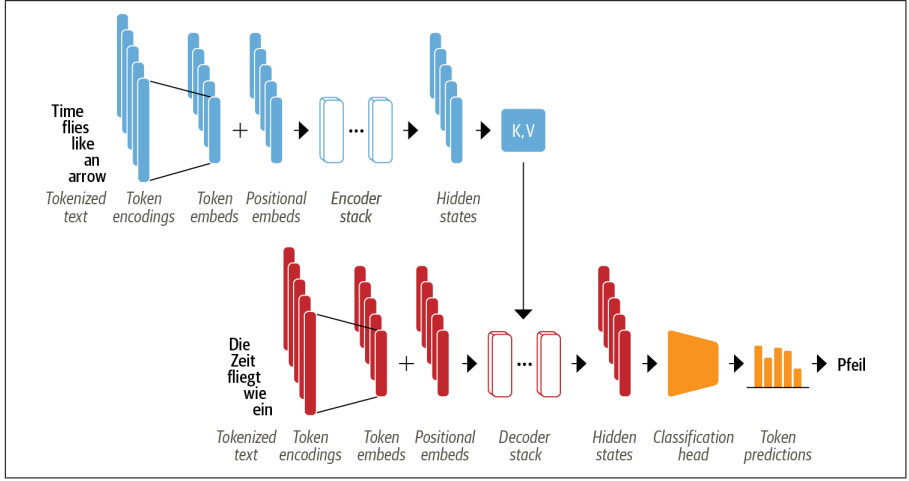

By looking at the figure above we can depict a few things regarding the architecture of the Transformers.

1. The text is tokenized and converted to **token embeddings**. Since the attention_mechanism is not aware of the relative positions of the tokens, we  need a way to inject some information about the positions of the tokens. This is done by finding the token positions. The final output is the combination of token embeds and positional embeds.   
2. The encoder is composed of stack of encoder layers or "blocks". Which is analogous to stacking convolutional layers in CV. The same is true for decoder.
3. The encoder output is then fed to the decoder. Now the decoder takes into account **2 things**. The *tokens generated by the decoder* and the *tokens fed directly to the decoder* to predict the next word. This process continues until a token (EOS) is generated and the generation of next words stops.

Although there are hundereds of different transformers, most of the models belong to one of the Encoder, Decoder, Encoder-Decoder architectures. 

1. Encoder-only: These models convert an input sequence of text into numerical representaion used for **text classification** or **named-entity-recognition(NER)**. BERT or its variants, like RoBERTa and DistilBERT belong to this class of architectures. We have *bidirectinal attention mechanism* in which the token before and after are affected.  
2. Decoder-only: In this models we have **completions tasks** in which a sentence is completed based on the other words in the text. This architecture uses *causal or autoregresive attention mechanism*. 
3. Encoder-Decoder: These architectures use mappings from one sequence to another; they are suitable for **machine translation** and **summarization tasks**. *BART* and *T5* models belong to this class of architectures.

# The Encoder

Each encoder layer consists of 2 sublayers:

1. A multi-head self-attention layer
2. a fully connected feed-forrward layer that is applied to each input embedding.

The output embeddings of each encoder layer have the same size of the inputs. So, basically, the main role of these layers is to update the input embeddings to produce representations that encode some contextual information in the sequence. For example, if the word "apple" is accompanied by keynote or phone is different then the "apple" as a fruit. 

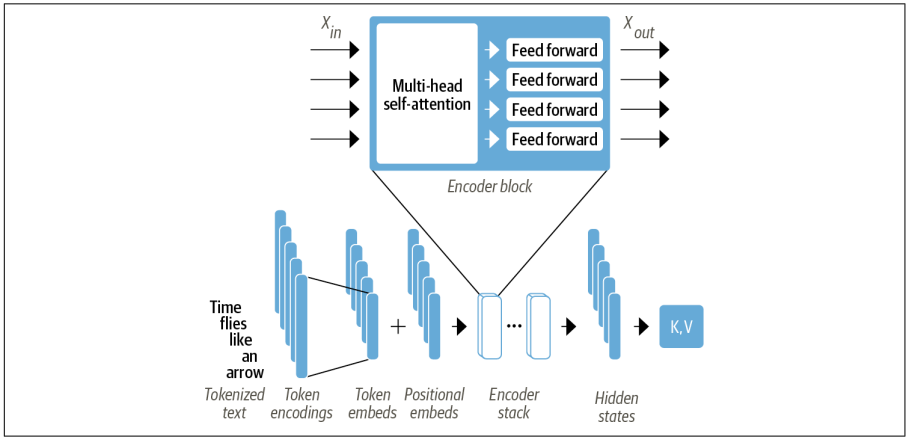



Each of these sublayers are also equiped with skip connections and layer normalizations, which are standard tricks for neural networks. We now go deeper and look at the most important part of an encoder: **Self-attention** layer. 

## Self-attention

Attention is a mechanism that allows neural networks to assign a different amount of weight or "attention" to each element in a sequence. for text sequences, the elements are *token embeddings*, where each token is mapped to a vector of some fixed dimension. For example in BERT, each token is represented as a 768-dimensional vector. The 'self' is referred to the fact that these weights are computed for all hidden states in the same set-for example, all the hidden states of the encoder layers. 

The main idea behind self-attention is that, we can use the whole sequnece of tokens to compute a weighted average of each embedding. Self-attention produces a sequence of new embeddings x1' , x2', x3', ..., xn' where each xi' is a linear combination of xj:

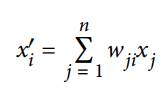

the coefficients wji are called *attention weights* and are normalized so that their sum is 1. The idea of self-attention is impportant when you have the word "flies" and you want to know if it means the insect or the verb. Embeddings that are generated in this way are called *contextualized embeddings*. 

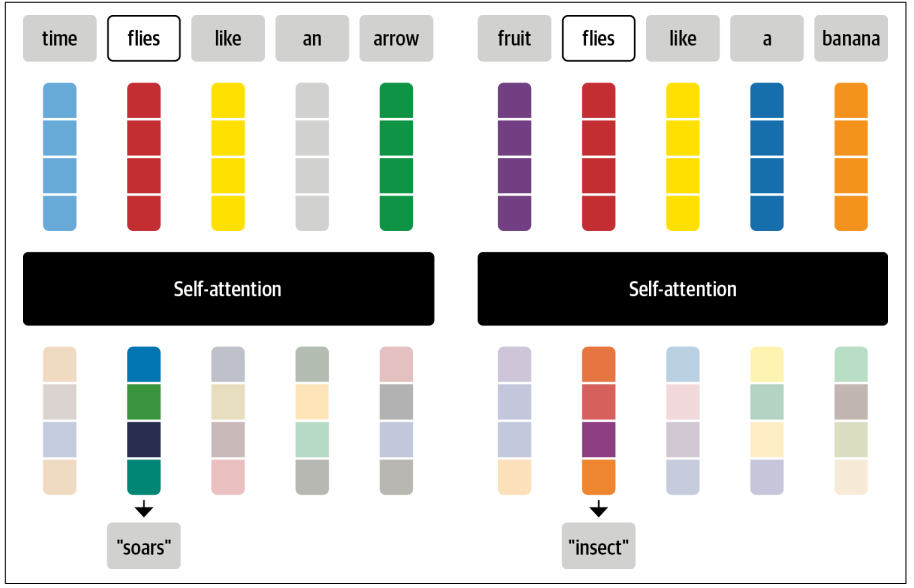

As seen in this picture, self-attention updates the *token embeddings* into *contextualized embeddings* to create representations that carries information from the whole sequence. 

But how can we calculate the attention weights?


### A. Scaled dot-product attention

One method to calculate the attention weights is scaled dot-product attention. There are 4 steps:

1. project each token embedding into three vectors called *query*, *key*, *value*.
2. Compute attention socres. We determine how much *query* and *key* vectors are related to each other using a *similarity function*. As the name suggests, the similarity function for scaled dot product is just the dot product computed 
3. 

In [4]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show


In [5]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

c:\Users\matin\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
100%|██████████| 440473133/440473133 [01:41<00:00, 4323324.81B/s] 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's see how we can construct an encoder using Pytorch

In [7]:
# First we tokenize our text
inputs = tokenizer(text,return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [11]:
# Here we create a Look-up embedding where I can pass my text to it and get a tensor of the shape [num_sequences(here it is 1), sequence_length(which is 5 here), hidden_size(which is the dimensional vector size of each token in BERT)]
from torch import nn
from transformers import AutoConfig


config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

Note: The token embeddings here do not contain any information about the context or meaning of different tokens. So one word with two meaning is treated the same. 

In [14]:
input_embeds = token_emb(inputs.input_ids)
input_embeds.size()

torch.Size([1, 5, 768])

Now we created the token embeddings. We will talk about positional embeddings later. We now build our query, key and value vectors and calculate the attention scores using similarity function which is dot-product.

In [ ]:
import torch 
from math import sqrt
# Set the 3 vectors as the input_embeds just for simplicity
query = key = value = input_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)

scores.size()

torch.Size([1, 5, 5])

In [17]:
# now we apply softmax
import torch.nn.functional as F
softmax_values = F.softmax(scores,dim=-1)
softmax_values.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [19]:
# multiply attention values by value vector
attn_outputs = torch.bmm(softmax_values, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [ ]:
# Let's create function so we can use it later
def scaled_dot_product_attention(query, key, value):
    dim_k = key.size(-1)
    scores = torch.bmm(query,key.transpose(1,2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)